## Imports

In [137]:

!pip install pmdarima
!pip install ta

import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import statsmodels.api as sm
from pmdarima import auto_arima
from ta.trend import SMAIndicator, MACD
from ta.momentum import RSIIndicator
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


## Data recuperation

In [138]:
stock_symbols = ['GOOGL', 'META', 'AMZN']
stock_ds = [f'dataset_{stock_symbol}.csv' for stock_symbol in stock_symbols]
# Charger le dataset depuis le fichier CSV
google = pd.read_csv(stock_ds[0], index_col='timestamp', parse_dates=True)
facebook = pd.read_csv(stock_ds[1], index_col='timestamp', parse_dates=True)
amazon = pd.read_csv(stock_ds[2], index_col='timestamp', parse_dates=True)

# Preprocessing the data (example: using closing prices)
data = pd.DataFrame({
    'Google': google['price'],
    'Facebook': facebook['price'],
    'Amazon': amazon['price'],
    'SP500': google['sp500'],
    'CAC40': google['cac40'],
    'Nikkei': google['nikkei'],
}).dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [139]:
data.dropna(inplace = True)
data

,Google,Facebook,Amazon,SP500,CAC40,Nikkei
Date,,,,,,
2021-01-08,89.891502,267.570007,159.134995,3824.679932,5706.879883,28139.029297
2021-01-12,86.871498,251.089996,156.041504,3801.189941,5650.970215,28164.339844
2021-01-13,87.362503,251.639999,158.294495,3809.840088,5662.669922,28456.589844
2021-01-14,86.545998,245.639999,156.373505,3795.540039,5681.140137,28698.259766
2021-01-15,86.380997,251.360001,155.212494,3768.250000,5611.689941,28519.179688
...,...,...,...,...,...,...
2023-12-27,140.369995,357.829987,153.339996,4781.580078,7571.819824,33681.238281
2023-12-28,140.229996,358.320007,153.380005,4783.350098,7535.160156,33539.621094
2023-12-29,139.690002,353.959991,151.940002,4769.830078,7543.180176,33464.171875


#### Feature engineering

In [140]:
def calculate_technical_indicators(data, companies=['Google', 'Amazon', 'Facebook']):
    """
    Calculate RSI and Moving Averages (SMA and EMA) for specified companies.
    """
    # Calculate RSI
    window_length_rsi = 14
    for company in companies:
        delta = data[company].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        roll_up = up.rolling(window_length_rsi).mean()
        roll_down = down.rolling(window_length_rsi).mean()
        RS = roll_up / roll_down
        data[f'{company}_RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Calculate Moving Averages
    sma_ema_windows = [5, 10, 20]
    for company in companies:
        for window in sma_ema_windows:
            data[f'{company}_SMA_{window}'] = data[company].rolling(window=window).mean()
            data[f'{company}_EMA_{window}'] = data[company].ewm(span=window, adjust=False).mean()

    return data

updated_data = calculate_technical_indicators(data)

updated_data.dropna(inplace= True)
updated_data

,Google,Facebook,Amazon,SP500,CAC40,Nikkei,Google_RSI,Amazon_RSI,Facebook_RSI,Google_SMA_5,Google_EMA_5,Google_SMA_10,Google_EMA_10,Google_SMA_20,Google_EMA_20,Amazon_SMA_5,Amazon_EMA_5,Amazon_SMA_10,Amazon_EMA_10,Amazon_SMA_20,Amazon_EMA_20,Facebook_SMA_5,Facebook_EMA_5,Facebook_SMA_10,Facebook_EMA_10,Facebook_SMA_20,Facebook_EMA_20
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-08,104.225998,266.579987,166.147003,3915.590088,5686.029785,29388.500000,77.333417,64.976296,54.795221,102.049800,101.911570,97.527500,98.982383,93.955200,95.859696,166.986200,166.345694,165.220149,165.340511,162.556324,163.614951,266.979993,266.755592,267.442996,266.741856,264.784499,266.453257
2021-02-09,103.769501,269.450012,165.250000,3911.229980,5691.540039,29505.929688,71.120237,53.781422,51.836659,103.612500,102.530880,98.364700,99.852768,94.649100,96.613011,166.236200,165.980462,165.114499,165.324055,162.862074,163.770670,267.453998,267.653732,266.182999,267.234248,264.878500,266.738662
2021-02-10,104.323997,271.869995,164.328995,3909.879883,5670.799805,29562.929688,71.551520,48.056659,49.013029,103.888499,103.128586,99.702400,100.665719,95.521725,97.347391,165.976700,165.429973,165.384499,165.143135,163.276449,163.823844,268.497998,269.059153,266.155997,268.077111,265.917500,267.227361
2021-02-12,104.751503,270.500000,163.885498,3934.830078,5703.669922,29520.070312,71.560006,48.601808,46.031748,104.302499,103.669558,100.911550,101.408589,96.391175,98.052544,165.443799,164.915148,165.584949,164.914474,163.555999,163.829716,269.300000,269.539436,266.705997,268.517636,266.860500,267.539041
2021-02-16,105.535004,273.970001,163.447495,3932.590088,5786.529785,30467.750000,72.380563,47.619860,45.988873,104.521201,104.291373,102.328251,102.158846,97.340625,98.765159,164.611798,164.425930,165.898698,164.647750,163.909698,163.793314,270.473999,271.016291,268.269998,269.508976,268.277000,268.151513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,140.369995,357.829987,153.339996,4781.580078,7571.819824,33681.238281,69.839234,64.695151,81.450894,139.453998,139.301721,136.270001,137.500213,134.738501,135.879830,153.301996,152.927858,151.428998,151.613957,148.859499,149.264255,352.989996,352.166300,344.662000,346.296784,335.508000,339.544973
2023-12-28,140.229996,358.320007,153.380005,4783.350098,7535.160156,33539.621094,72.380519,72.533042,82.690824,140.169998,139.611146,137.041000,137.996538,134.890001,136.294131,153.219998,153.078574,152.018999,151.935057,149.177000,149.656231,354.582001,354.217536,347.072000,348.482825,336.474501,341.333071
2023-12-29,139.690002,353.959991,151.940002,4769.830078,7543.180176,33464.171875,58.394189,63.500512,73.705208,140.439999,139.637432,137.753000,138.304440,135.125001,136.617548,153.184000,152.699050,152.328999,151.935956,149.457999,149.873733,355.517999,354.131688,348.994000,349.478673,337.562500,342.535635


## Batch Methods

### Linear Regression

Google - MSE: 0.6638515096507187 R^2: 0.9832878764289519
Facebook - MSE: 4.699558248186345 R^2: 0.9887646983518262
Amazon - MSE: 0.8419433738156142 R^2: 0.9880674012493826


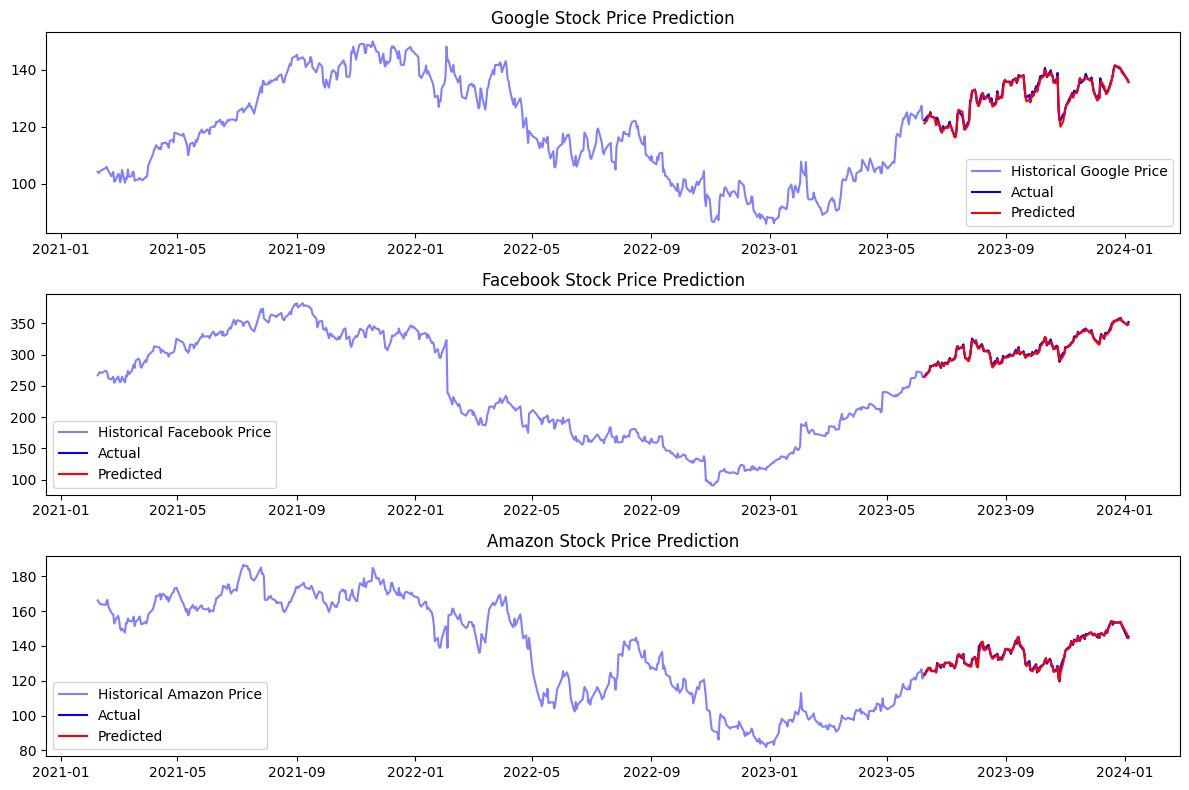

,Stock,MSE,R^2
0,Google,0.663852,0.983288
1,Facebook,4.699558,0.988765
2,Amazon,0.841943,0.988067


In [141]:
def create_and_evaluate_model(stock_name, data):
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle = False)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, y_test, y_pred

# Create and evaluate models for each stock
google_mse, google_r2, google_y_test, google_y_pred = create_and_evaluate_model('Google', data)
facebook_mse, facebook_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_model('Facebook', data)
amazon_mse, amazon_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_model('Amazon', data)

# Output the results
print("Google - MSE:", google_mse, "R^2:", google_r2)
print("Facebook - MSE:", facebook_mse, "R^2:", facebook_r2)
print("Amazon - MSE:", amazon_mse, "R^2:", amazon_r2)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'MSE': [google_mse, facebook_mse, amazon_mse],
    'R^2': [google_r2, facebook_r2, amazon_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))

# Google
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Google'], label=f'Historical Google Price', color='blue', alpha=0.5)
plt.plot(google_y_test.index, google_y_test, label='Actual', color='blue')
plt.plot(google_y_test.index, google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Facebook'], label=f'Historical Facebook Price', color='blue', alpha=0.5)
plt.plot(facebook_y_test.index, facebook_y_test, label='Actual', color='blue')
plt.plot(facebook_y_test.index, facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Amazon'], label=f'Historical Amazon Price', color='blue', alpha=0.5)
plt.plot(amazon_y_test.index, amazon_y_test, label='Actual', color='blue')
plt.plot(amazon_y_test.index, amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction')
plt.legend()

plt.tight_layout()
plt.show()

results_df


### XGboost

In [142]:
data = updated_data
data

,Google,Facebook,Amazon,SP500,CAC40,Nikkei,Google_RSI,Amazon_RSI,Facebook_RSI,Google_SMA_5,Google_EMA_5,Google_SMA_10,Google_EMA_10,Google_SMA_20,Google_EMA_20,Amazon_SMA_5,Amazon_EMA_5,Amazon_SMA_10,Amazon_EMA_10,Amazon_SMA_20,Amazon_EMA_20,Facebook_SMA_5,Facebook_EMA_5,Facebook_SMA_10,Facebook_EMA_10,Facebook_SMA_20,Facebook_EMA_20
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-08,104.225998,266.579987,166.147003,3915.590088,5686.029785,29388.500000,77.333417,64.976296,54.795221,102.049800,101.911570,97.527500,98.982383,93.955200,95.859696,166.986200,166.345694,165.220149,165.340511,162.556324,163.614951,266.979993,266.755592,267.442996,266.741856,264.784499,266.453257
2021-02-09,103.769501,269.450012,165.250000,3911.229980,5691.540039,29505.929688,71.120237,53.781422,51.836659,103.612500,102.530880,98.364700,99.852768,94.649100,96.613011,166.236200,165.980462,165.114499,165.324055,162.862074,163.770670,267.453998,267.653732,266.182999,267.234248,264.878500,266.738662
2021-02-10,104.323997,271.869995,164.328995,3909.879883,5670.799805,29562.929688,71.551520,48.056659,49.013029,103.888499,103.128586,99.702400,100.665719,95.521725,97.347391,165.976700,165.429973,165.384499,165.143135,163.276449,163.823844,268.497998,269.059153,266.155997,268.077111,265.917500,267.227361
2021-02-12,104.751503,270.500000,163.885498,3934.830078,5703.669922,29520.070312,71.560006,48.601808,46.031748,104.302499,103.669558,100.911550,101.408589,96.391175,98.052544,165.443799,164.915148,165.584949,164.914474,163.555999,163.829716,269.300000,269.539436,266.705997,268.517636,266.860500,267.539041
2021-02-16,105.535004,273.970001,163.447495,3932.590088,5786.529785,30467.750000,72.380563,47.619860,45.988873,104.521201,104.291373,102.328251,102.158846,97.340625,98.765159,164.611798,164.425930,165.898698,164.647750,163.909698,163.793314,270.473999,271.016291,268.269998,269.508976,268.277000,268.151513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,140.369995,357.829987,153.339996,4781.580078,7571.819824,33681.238281,69.839234,64.695151,81.450894,139.453998,139.301721,136.270001,137.500213,134.738501,135.879830,153.301996,152.927858,151.428998,151.613957,148.859499,149.264255,352.989996,352.166300,344.662000,346.296784,335.508000,339.544973
2023-12-28,140.229996,358.320007,153.380005,4783.350098,7535.160156,33539.621094,72.380519,72.533042,82.690824,140.169998,139.611146,137.041000,137.996538,134.890001,136.294131,153.219998,153.078574,152.018999,151.935057,149.177000,149.656231,354.582001,354.217536,347.072000,348.482825,336.474501,341.333071
2023-12-29,139.690002,353.959991,151.940002,4769.830078,7543.180176,33464.171875,58.394189,63.500512,73.705208,140.439999,139.637432,137.753000,138.304440,135.125001,136.617548,153.184000,152.699050,152.328999,151.935956,149.457999,149.873733,355.517999,354.131688,348.994000,349.478673,337.562500,342.535635


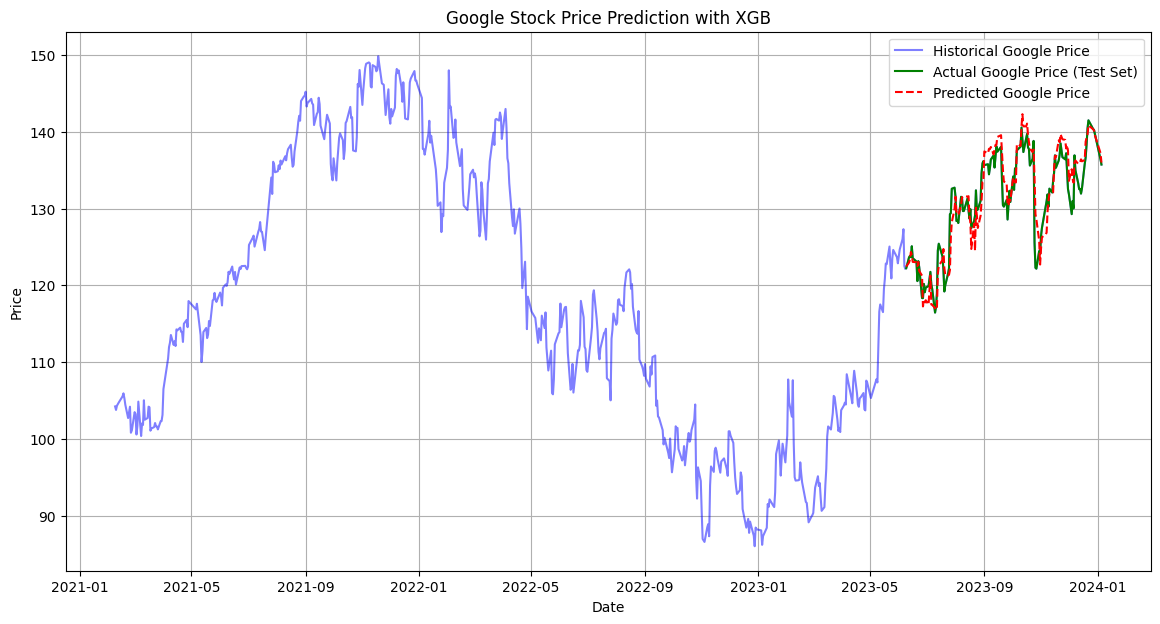

Google Mean Squared Error: 5.844900484665052
Google R-squared: 0.8528576078533048


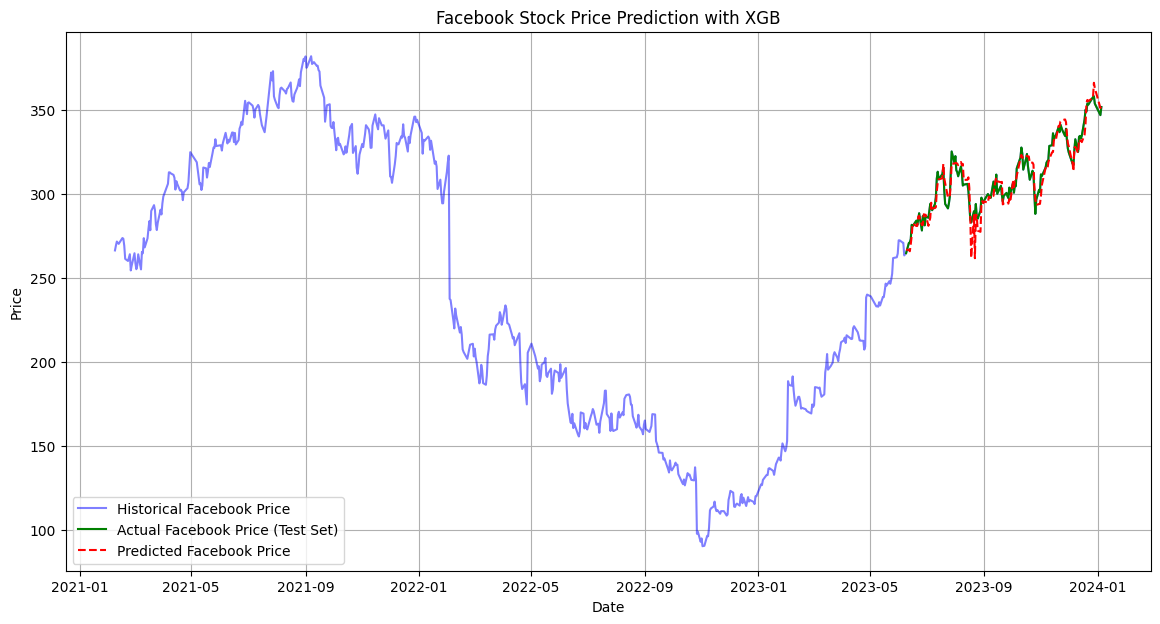

Facebook Mean Squared Error: 34.84896092282703
Facebook R-squared: 0.9166860867732652


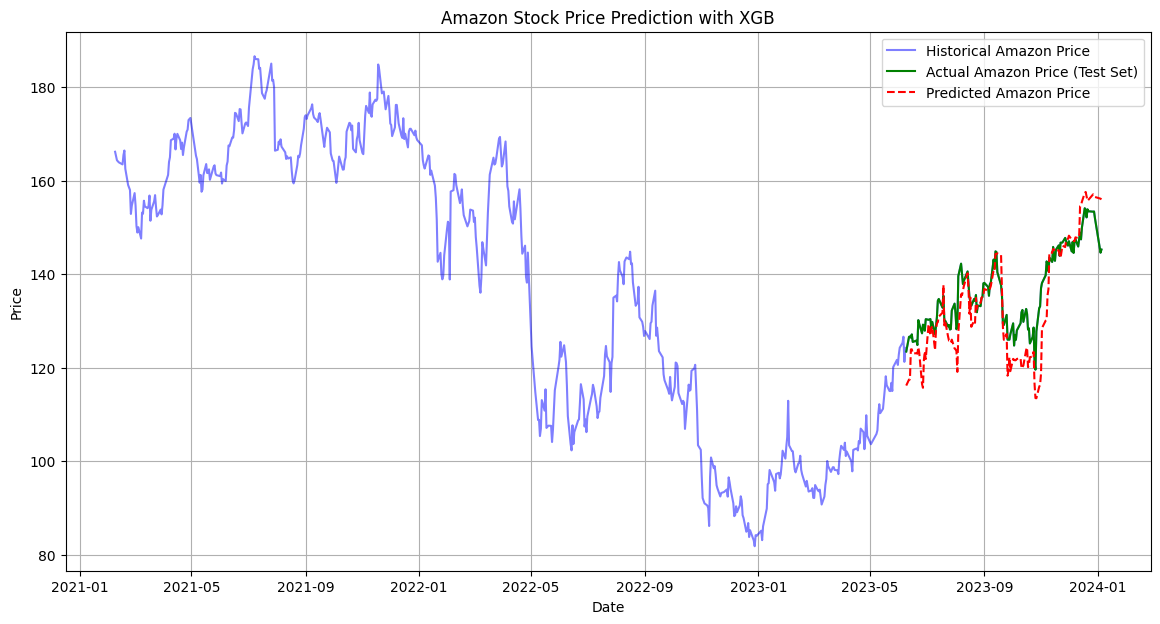

Amazon Mean Squared Error: 34.52122895999125
Amazon R-squared: 0.5107414745828498


,Company,MSE,R-squared
0,Google,5.844900,0.852858
1,Facebook,34.848961,0.916686
2,Amazon,34.521229,0.510741


In [143]:

# 6. Splitting the dataset, 7. Building the XGBoost model, 8. Visualizing the results, 9. Evaluating the model
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

results_df = pd.DataFrame(columns=['Company', 'MSE', 'R-squared'])

for company in ['Google', 'Facebook', 'Amazon']:
    # Splitting the dataset
    features = [col for col in data.columns if col not in ['SP500', 'CAC40', 'Nikkei', 'Google', 'Facebook', 'Amazon']]
    X = data[features]
    y = data[company]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Building the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Visualizing the results
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data[company], label=f'Historical {company} Price', color='blue', alpha=0.5)
    plt.plot(X_test.index, y_test, label=f'Actual {company} Price (Test Set)', color='green')
    plt.plot(X_test.index, y_pred, label=f'Predicted {company} Price', color='red', linestyle='--')
    plt.title(f'{company} Stock Price Prediction with XGB')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Printing the metrics
    print(f"{company} Mean Squared Error:", mse)
    print(f"{company} R-squared:", r2)

    results_df = results_df.append({'Company': company, 'MSE': mse, 'R-squared': r2}, ignore_index=True)
results_df

In [144]:
results_df

,Company,MSE,R-squared
0,Google,5.844900,0.852858
1,Facebook,34.848961,0.916686
2,Amazon,34.521229,0.510741
